In [1]:
#Импортируем необходимые библиотеки
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from scipy.stats import t
import warnings
from copy import deepcopy
#Новая библиотека с выделенными функциями
import tools_for_mv1 as tfm
#import tools_for_mv as tfm
warnings.filterwarnings('ignore')

Датасет взят из следующего источника: https://www.openml.org/search?type=data&sort=runs&id=192&status=active

In [2]:
f1=open('vineyard.arff','r')

In [3]:
# Считываем датасет из файла, отдельно метки, отдельно признаки
Data, labels = [], []
for line in f1:
    if line[0].isdigit():
        row_number, first, second, third = line.split(',')    
        Data.append([float(first), float(second)])
        labels.append(third[0])
Data=np.array(Data)

Убедимся, что получился корректный датасет

In [4]:
print(Data[:5])

[[ 1.   5. ]
 [ 3.   8. ]
 [ 3.  11. ]
 [ 3.   9. ]
 [ 5.   9.5]]


Посмотрим, сколько уникальных значений меток имеется:

In [5]:
print(f"Число разных классов для датасета: {len(set(labels))}")

Число разных классов для датасета: 2


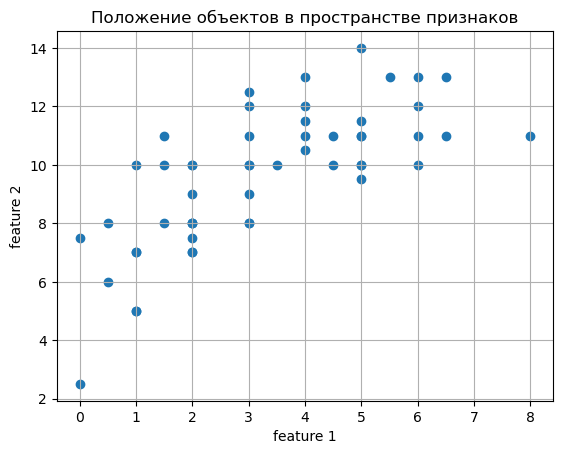

In [6]:
plt.title("Положение объектов в пространстве признаков")
plt.scatter(Data[:,0], Data[:,1])
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.grid()
plt.show()

In [7]:
Data_P, Data_N = [], []
for i in range(len(labels)):
    if labels[i]=='P':
        Data_P.append(list(Data[i]))
    if labels[i]=='N':
        Data_N.append(list(Data[i]))
Data_P=np.array(Data_P)
Data_N=np.array(Data_N)

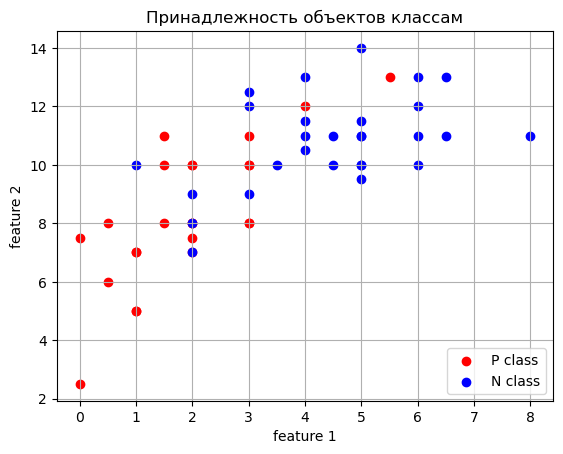

In [8]:
plt.title("Принадлежность объектов классам")
plt.scatter(Data_P[:,0], Data_P[:,1], color='red', label='P class')
plt.scatter(Data_N[:,0], Data_N[:,1], color='blue', label='N class')
plt.legend(loc='lower right')
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.grid()
plt.show()

Теперь стоит создать версии датасета с пропусками различных типов:
MCAR (уберем половину случайно выбранных данных по второму признаку),
MAR (уберем данные по второму признаку для объектов у которых значение первого признака выше определенного порога).

In [9]:
print(f"Математическое ожидание наблюдаемых данных={np.mean(Data[:,0])},\nМедиана наблюдаемых данных={np.median(Data[:,0])}")

Математическое ожидание наблюдаемых данных=3.2788461538461537,
Медиана наблюдаемых данных=3.0


In [10]:
# Проверим, есть ли объекты, у которых значение первого признака лежит между медианой и мат.ожиданием.
for i in range(len(Data)):
    sum_ = 0
    if Data[i,0]>3 and Data[i,0]<=3.2788461538461537:
        sum_+=1
print(sum_)

0


Таких объектов нет. Это означает, что медиана и мат.ожидание одинаковым образом делят значение первого признака на две части.

Из этого следует, что, если создать пропуски типа MAR для второго признака, при условии что значение первого признака больше/меньше определенного порога,
выбор медианы первого признака в качестве порогового значения даст те же пропуски, что и выбор мат.ожидания первого признака.

In [11]:
# Создаем версию датасета со случайными пропусками, x_i2 становится пропуском, если x_i1>E[x1]
D_MAR = tfm.MAR(Data,np.mean(Data[:,0]), 'more')

In [12]:
# Создаем версию датасета с абсолютно случайными пропусками, т.е. независящими от наблюдаемых данных, 50% пропусков
D_MCAR = tfm.MCAR(Data, 26)

In [13]:
# Генерируем 8 датасетов (4 способа заполнить данные X 2 типа пропусков (MAR,MCAR))
D_MAR1, D_MAR2, D_MAR3, D_MAR4 = tfm.mean_fill(D_MAR), tfm.lr_fill(D_MAR), tfm.slr_fill(D_MAR), tfm.EM(D_MAR)
D_MCAR1, D_MCAR2, D_MCAR3, D_MCAR4 = tfm.mean_fill(D_MCAR), tfm.lr_fill(D_MCAR), tfm.slr_fill(D_MCAR), tfm.EM(D_MCAR)

L(Y)=-371.78154934886993,r=0.9443305612876821,s1=3.6866678994082847,s12=252.96792612510114,s2=19464.74924700716
Step: 0  Loss -10629.55

L(Y)=-449.0696154811941,r=0.9117985554741923,s1=3.6866678994082847,s12=250.10461007625395,s2=20408.52307572268
Step: 1  Loss -12863.79

L(Y)=-447.36163033195146,r=0.8945875890519477,s1=3.6866678994082847,s12=231.99448590506051,s2=18242.13100435752
Step: 2  Loss -12813.43

L(Y)=-443.4375011172632,r=0.8859739605121217,s1=3.6866678994082847,s12=214.3290984439347,s2=15873.998729126786
Step: 3  Loss -12700.57

L(Y)=-439.42513180789734,r=0.8818010029785548,s1=3.6866678994082847,s12=197.9848629511249,s2=13673.786045359693
Step: 4  Loss -12585.89

L(Y)=-435.4224140547204,r=0.8798945231521779,s1=3.6866678994082847,s12=182.91567211355715,s2=11722.131470967337
Step: 5  Loss -12471.83

L(Y)=-431.4367760977218,r=0.8791637968832806,s1=3.6866678994082847,s12=169.0253569415106,s2=10026.055724812508
Step: 6  Loss -12358.43

L(Y)=-427.4697243691911,r=0.879056957900168,

In [14]:
#Эта функция оценивает качество классификации для набора данных, который подается на вход (два признака+метки)
def checking(Data,labels):
    y = list()
    for i in range(len(labels)):
        if labels[i]=="N":
            y.append(0)
        if labels[i]=="P":
            y.append(1)
    X_train, X_test, y_train, y_test = train_test_split(Data, y, test_size=0.3, random_state=42)
    reg = linear_model.RidgeClassifier(alpha=0.1)
    reg.fit(X_train, y_train)
    prediction = reg.predict(X_test)
    metrics_res = {}
    metrics_res['f1_score'] = metrics.f1_score(y_test, prediction)
    metrics_res['accuracy'] = metrics.accuracy_score(y_test, prediction)
    metrics_res['precision'] = metrics.precision_score(y_test, prediction)
    metrics_res['recall'] = metrics.recall_score(y_test, prediction)
    return metrics_res
    

Проверим, как решается задача классификации, если заполнялись пропуски типа MCAR (абсолютно случайных) для четырех методов: 

заполнение средним, заполнение по регрессии, стохастическое заполнение по регрессии, использование ЕМ-алгоритма.

Повторим аналогичные действия для пропусков типа MAR (зависящих от наблюдаемых данных).

Будем использовать 4 метрики для оценки решения задачи классификации: 
Accuracy (доля правильных прогнозов)
    
Precision (точность): $$Precision=\frac{\Sigma TP}{\Sigma TP+ \Sigma FP}$$

Recall (полнота): $$Recall=\frac{\Sigma TP}{\Sigma TP+ \Sigma FN}$$

F1-мера: $$F1=2*\frac{Precision*Recall}{Precision+Recall}$$
    
Где - $TP$ - истинно-положительная классификация объекта, $FP$ - ложно-положительная классификация объекта, $FN$ - ложно-отрицательная классификация объекта.

In [15]:
methods = ['заполнение средним', 'заполнение по регрессии',
           'стохастическое заполнение по регрессии','использование ЕМ-алгоритма']
mv_types = ['MCAR', 'MAR']
df_index = ['MCAR,mean', 'MCAR,reg', 'MCAR,stoch_reg', 'MCAR,EM',
          'MAR,mean', 'MAR,reg', 'MAR,stoch_reg', 'MAR,EM',]
df_columns = ['f1_score', 'accuracy', 'precision', 'recall']
data_list1 = [[D_MCAR1, D_MCAR2, D_MCAR3, D_MCAR4],
           [D_MAR1, D_MAR2, D_MAR3, D_MAR4]]

In [16]:
results = np.zeros((8,4))
for i in range(len(mv_types)):
    for j in range(len(methods)):
        results[4*i+j] = list(checking(data_list1[i][j], labels).values())
df1 = pd.DataFrame(data=results, index=df_index, columns=df_columns)

In [17]:
df1

,f1_score,accuracy,precision,recall
"MCAR,mean",0.800000,0.8125,0.750000,0.857143
"MCAR,reg",0.800000,0.8125,0.750000,0.857143
"MCAR,stoch_reg",0.800000,0.8125,0.750000,0.857143
"MCAR,EM",0.800000,0.8125,0.750000,0.857143
"MAR,mean",0.923077,0.9375,1.000000,0.857143
"MAR,reg",0.769231,0.8125,0.833333,0.714286
"MAR,stoch_reg",0.769231,0.8125,0.833333,0.714286
"MAR,EM",0.800000,0.8125,0.750000,0.857143


Попробуем создать большее число пропусков, порядка 70%, вместо половины (по второму признаку).

In [18]:
# Создаем версию датасета со случайными пропусками, x_i2 становится пропуском, если x_i1 больше квантиля 0.7 для признака x1
D1_MAR = tfm.MAR(Data,np.quantile(Data[:,0], 0.3), 'more')

In [19]:
# Создаем версию датасета с абсолютно случайными пропусками, т.е. независящими от наблюдаемых данных, 70% пропусков
D1_MCAR = tfm.MCAR(Data, 36)

In [20]:
D1_MAR1, D1_MAR2, D1_MAR3, D1_MAR4 = tfm.mean_fill(D1_MAR), tfm.lr_fill(D1_MAR), tfm.slr_fill(D1_MAR), tfm.EM(D1_MAR)
D1_MCAR1, D1_MCAR2, D1_MCAR3, D1_MCAR4 = tfm.mean_fill(D1_MCAR), tfm.lr_fill(D1_MCAR), tfm.slr_fill(D1_MCAR), tfm.EM(D1_MCAR)

L(Y)=-370.71641166990673,r=1.1730343091178939,s1=3.6866678994082847,s12=343.621185686741,s2=23275.78931284201
Step: 0  Loss nan

L(Y)=-525.594839087036,r=0.9943436660129044,s1=3.6866678994082847,s12=484.81501408785607,s2=64482.977247087576
Step: 1  Loss -6250.57

L(Y)=-1126.9964846938253,r=0.9818676446623634,s1=3.6866678994082847,s12=538.8696590791078,s2=81701.0329500016
Step: 2  Loss -13459.02

L(Y)=-1658.3153741295655,r=0.9781653798220732,s1=3.6866678994082847,s12=558.2845658044516,s2=88359.37803607347
Step: 3  Loss -19833.27

L(Y)=-1828.849403416019,r=0.9757023641168826,s1=3.6866678994082847,s12=563.9370583264265,s2=90613.4231153777
Step: 4  Loss -21878.90

L(Y)=-1871.30923454683,r=0.9737157784503339,s1=3.6866678994082847,s12=564.1293235318899,s2=91045.59060483688
Step: 5  Loss -22387.92

L(Y)=-1883.1025852845503,r=0.9721035916312588,s1=3.6866678994082847,s12=562.1628064052313,s2=90712.07561279938
Step: 6  Loss -22529.11

L(Y)=-1886.8989315020453,r=0.9708161519866504,s1=3.6866678994

In [21]:
data_list2 = [[D1_MAR1, D1_MAR2, D1_MAR3, D1_MAR4],
           [D1_MCAR1, D1_MCAR2, D1_MCAR3, D1_MCAR4]]

In [22]:
results = np.zeros((8,4))
for i in range(len(mv_types)):
    for j in range(len(methods)):
        results[4*i+j] = list(checking(data_list2[i][j], labels).values())
df2 = pd.DataFrame(data=results, index=df_index, columns=df_columns)

In [23]:
df2

,f1_score,accuracy,precision,recall
"MCAR,mean",0.727273,0.8125,1.00,0.571429
"MCAR,reg",0.833333,0.8750,1.00,0.714286
"MCAR,stoch_reg",0.833333,0.8750,1.00,0.714286
"MCAR,EM",0.800000,0.8125,0.75,0.857143
"MAR,mean",0.800000,0.8125,0.75,0.857143
"MAR,reg",0.800000,0.8125,0.75,0.857143
"MAR,stoch_reg",0.800000,0.8125,0.75,0.857143
"MAR,EM",0.800000,0.8125,0.75,0.857143


**Выводы:** При пропусках типа MCAR заполнение средним показывает довольно плохие результаты, однако при пропусках типа MAR заполнение средним, применительно к данному датасету, может привести к  хорошему качеству классификации. Стохастическое заполнение по регрессии показывает одинаково высокое значение f-меры во всех рассмотренных ситуациях, значение полноты и значение точности сбалансированы. Заполнение по регрессии и ЕМ-алгоритм при MAR-пропусках (доля 50%) и MCAR-пропусках (доля 70%) дают значительно худший результат по F1-мере. Причем,  значение метрики recall (полноты) оказывается значительно меньше значения метрики precision (точность). При 70% MAR пропусков ни один метод на данном датасете не проявляет себя лучше другого.